# Load PAT module and packages

In [4]:
%load_ext autoreload
%autoreload 2
from pat import data, utils
import json, os, glob
import pandas as pd, numpy as np
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style('white')
from tqdm import tqdm

# Load data directly as pose2D format

In [5]:
# Extract keypoints.json files into one composite csv Frame x 75 Keypoints
from pat.data import pose2d_cols
from joblib import Parallel, delayed
os.chdir('C:/Users/Catarina/Desktop/MIND2019/pat/notebooks/')
fnames = np.sort(glob.glob('output/json/*_keypoints.json'))
new_df_fname = 'output/Sherlock_full_par.csv'
if not os.path.exists(new_df_fname):
    result = Parallel(n_jobs=3)(delayed(utils.load_keypoints_2d)(fname, os.path.split(fname)[1].split('_')[1], new_df_fname) for fname in fnames)
else:
    # Load the data back with multiindex and column names. 
    df = pd.read_csv(new_df_fname, header=None, index_col=[0, 1], names=pose2d_cols)
    df.index.names=['frame','personID']
    df = df.sort_values(['frame','personID'])
    print(df.pat._type)

Pose2D


# Set some functions

In [13]:
def center_of_mass(pose_df):
    '''Calculate centre of mass of one person
    Args:
          pose_df: pose_2d dataframe
    Return:
          Dataframe with center of mass (calculated as average x,y of pose keypoints) for each frame
    ''' 
    pose_x = []
    pose_y = []
    x_index = pose_df.columns.str.startswith('x_')
    y_index = pose_df.columns.str.startswith('y_')

    for frame_ix in range(len(pose_df)):
        x_coords = pose_df.iloc[frame_ix,x_index]
        y_coords = pose_df.iloc[frame_ix,y_index]
        av_x = x_coords[x_coords != 0].mean()
        av_y = y_coords[y_coords != 0].mean()
        pose_x.append(av_x) 
        pose_y.append(av_y) 
        
    com = np.transpose(np.array([pose_x, pose_y]))
    return pd.DataFrame(com, index = pose_df.index.get_level_values('frame'), columns = ['mean_x','mean_y'])



def pose_diff (p0, p1, keypoints):
    '''
    Args:
        p0: pose_2d dataframe from person 1
        p1: pose_2d dataframe from person 2
        keypoints: on what keypoints to compute difference
                   options 'all' or keypoint number (between 0 and 24 or any combination of those)
                   NOTE: 75 keypoints in (x1,y1,c1, x2,y2,c2,...) where x is x coord, y is y coord, and c is confidence 
                   function assumes Pose Output Format (BODY_25) from OpenPose
    Return:
        Data frames with differences in x coordinate and then in y coordinate
    '''
        
    x_diff = []; y_diff = []
    idx = p0.index.get_level_values('frame')  

    if len(keypoints) == 1 and keypoints == ['all']:
        x_index = p0.columns.str.startswith('x_')
        y_index = p0.columns.str.startswith('y_')
        col_x = p0.columns[p0.columns.str.startswith('x_')]
        col_y = p0.columns[p0.columns.str.startswith('y_')]
        
    elif len(keypoints) == 1 and keypoints != ['all']:
            x_index = p0.columns.str.startswith('x_'+keypoints[0])
            y_index = p0.columns.str.startswith('y_'+keypoints[0])
            col_x = p0.columns[p0.columns.str.startswith('x_'+keypoints[0])]
            col_y = p0.columns[p0.columns.str.startswith('y_'+keypoints[0])] 
            
    for frame_ix in range(len(p0)):
        x = p0.iloc[frame_ix,x_index]-p1.iloc[frame_ix,x_index]
        y = p0.iloc[frame_ix,y_index]-p1.iloc[frame_ix,y_index]
        x_diff.append(x)
        y_diff.append(y)

    x = pd.DataFrame(np.array(x_diff), index = idx, columns = col_x)
    y = pd.DataFrame(np.array(y_diff), index = idx, columns = col_y)    

    return pd.concat([x,y],axis=1, sort=False)
        

In [7]:
#get center of mass for two different people, filtered by confidence
p0 = df.loc[df.index.get_level_values('personID') == -1]
p1 = df.loc[df.index.get_level_values('personID') == -0]

p0_filt = p0.pat.filter_pose_confidence()
p1_filt = p1.pat.filter_pose_confidence()

p0_com = center_of_mass (p0_filt)
p1_com = center_of_mass (p1_filt)

[(150, 300), (50, 300)]

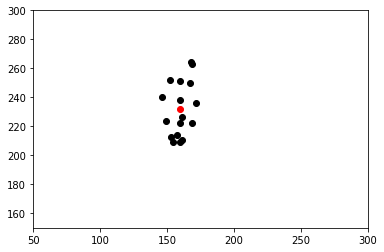

In [10]:
#quick and dirty plot just to check if com actually seems to be in the center of the pose (one frame, one person)
x_coords = p0_filt.iloc[2,0:72:3].values
x_coords = x_coords[x_coords != 0]

y_coords = p0_filt.iloc[2,1:73:3].values
y_coords = y_coords[y_coords != 0]

x_com = p0_com['mean_x'].iloc[2]
y_com = p0_com['mean_y'].iloc[2]


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.clear()
ax.scatter(x_coords,y_coords, c = 'k')
ax.scatter(x_com,y_com, c = 'r')
ax.set(xlim=[50,300],ylim=[150,300])

In [14]:
#get the distance between two people for all keypoints in each frame
diff_all = pose_diff(p0_filt, p1_filt, ['all'])

#get the distance between two people for one of the keypoints in each frame
diff_nose = pose_diff(p0_filt, p1_filt, ['Nose'])

#note that some keypoints will have information for left AND right. In those cases, you might want to specify what side
diff_rWrist = pose_diff(p0_filt, p1_filt, ['RWrist'])

#STILL WORKING ON THIS ONE (just figuring out the best way to store the information)
#get the distance between two people for a few different keypoints in each frame
#diff_nose = pose_diff(p0_filt, p1_filt, ['Nose', 'Neck', 'RWrist'])

ALSO STILL WORKING ON: 
- I just noticed I'm taking all the frames when computing differences, when it only makes sense to compute them when the 2 (or more) people are on the screen at the same time. Changing that now
- Is there a nice (useful way) to plot these differences
- Normalization (have a few questions about using procrustes
